
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Simulate Astronomical Tide using ttide library

inputs required: 
  * Astronomical Tide historical time series at the study site 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op

# python libs
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib

# custom libs
import utide # https://github.com/wesleybowman/UTide

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.plotting.tides import Plot_AstronomicalTide, Plot_ValidateTTIDE, Plot_Validate_scatter



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# Load astronomical tide historical and set simulation dates

TIDE_astro = db.Load_TG()          # astronomical tide historical data
print(TIDE_astro)

# TG latitude
lat0 = 9.75

# Simulation dates
d1_sim = np.datetime64('1700-01-01')
d2_sim = np.datetime64('2700-01-01')


<xarray.Dataset>
Dimensions:     (time: 342357)
Coordinates:
  * time        (time) datetime64[ns] 1975-12-31T12:00:00 ... 2014-02-11T12:00:00
Data variables:
    TIDE        (time) float64 ...
    NTR         (time) float64 ...
    WaterLevel  (time) float64 ...



## Astronomical Tide

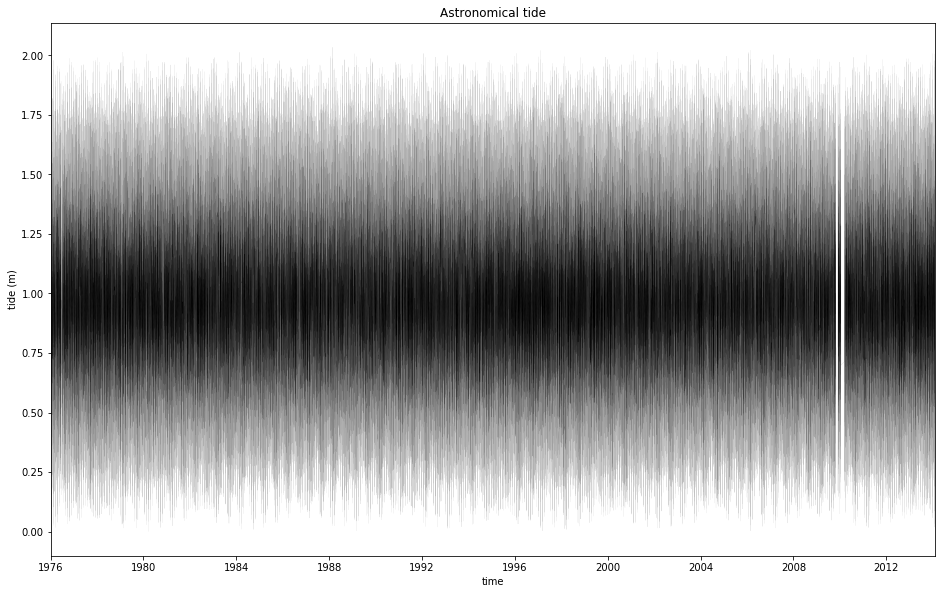

In [4]:
# --------------------------------------
# astronomical tide data

TIDE = TIDE_astro.TIDE

# remove tide nanmin
TIDE = TIDE - np.nanmin(TIDE)

# Plot astronomical tide
time = TIDE.time.values[:]
tide = TIDE.values[:]

Plot_AstronomicalTide(time, tide);



## Astronomical Tide - Fitting

solve: matrix prep ... solution ... diagnostics ... done.
dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn'])

prep/calcs ... done.
dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])


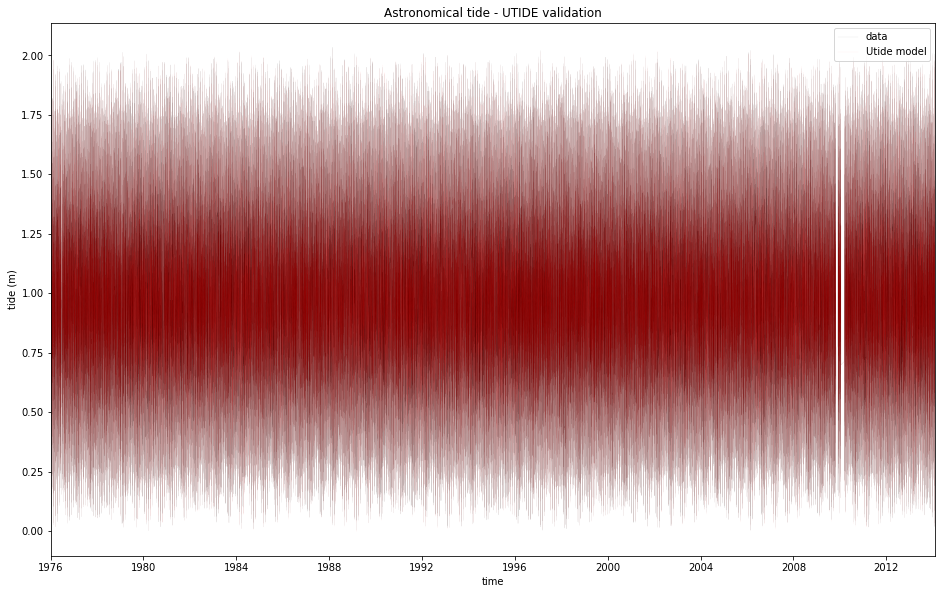

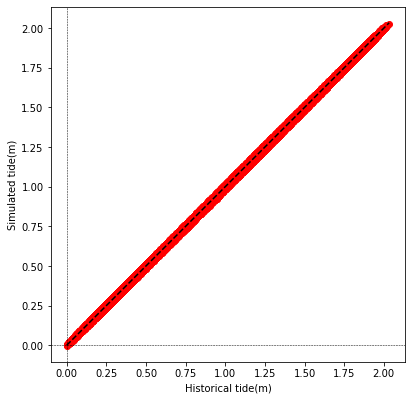

In [5]:
# --------------------------------------
# Utide library - Validation
coef = utide.solve(matplotlib.dates.date2num(time), tide,
                   lat=lat0,
                   nodal=True,
                   method='ols',
                   conf_int='MC')
print(coef.keys())
print()

tide_tt = utide.reconstruct(matplotlib.dates.date2num(time), coef)
print(tide_tt.keys())
tide_tt = tide_tt.h

# Plot validation 
Plot_ValidateTTIDE(time, tide, tide_tt);
Plot_Validate_scatter(tide, tide_tt, 'Historical tide(m)', 'Simulated tide(m)');



## Astronomical Tide - Prediction

In [8]:
# TODO: too slow (0.5 h). try using smaller time blocks

# --------------------------------------
# Utide library - Prediction
date_pred = np.arange(d1_sim, d2_sim + np.timedelta64(1,'h'), dtype='datetime64[h]')

atide_pred = utide.reconstruct(matplotlib.dates.date2num(date_pred), coef)
atide_pred = atide_pred.h

# store data
ASTRO_sim = xr.Dataset(
    {
        'astro'   :(('time',), atide_pred),
    },
    {'time' : date_pred.astype(datetime)}
)

print(ASTRO_sim)

db.Save_TIDE_sim_astro(ASTRO_sim)


<xarray.Dataset>
Dimensions:  (time: 8765809)
Coordinates:
  * time     (time) object 1700-01-01 1700-01-01T01:00:00 ... 2700-01-01
Data variables:
    astro    (time) float64 1.36 1.417 1.377 1.249 ... 1.063 0.7207 0.4283 0.267


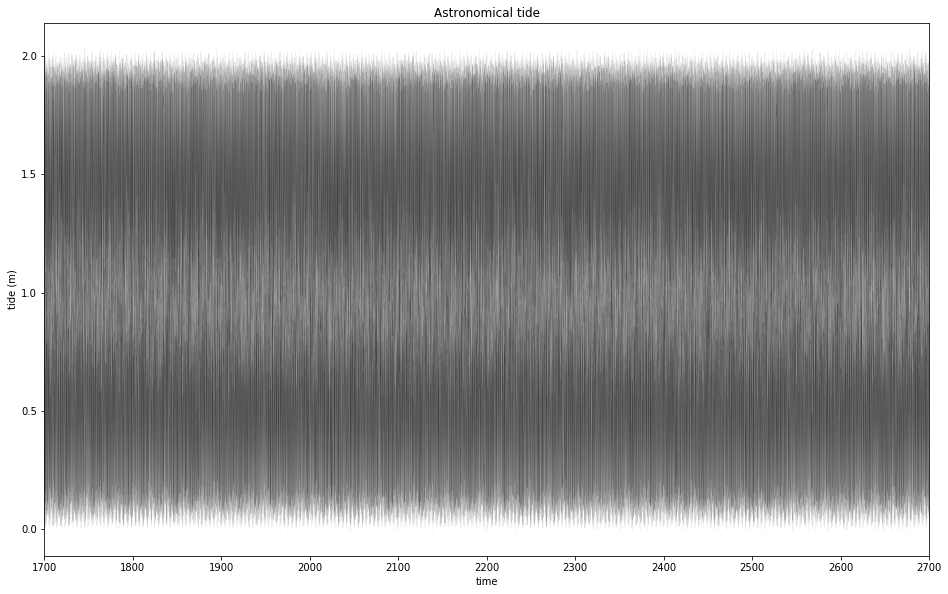

In [9]:
# Plot astronomical tide prediction
time = ASTRO_sim.time.values[:]
tide = ASTRO_sim.astro.values[:]

Plot_AstronomicalTide(time, tide);
